In [1]:
import pyodbc
from sqlalchemy import create_engine
import pandas as pd

conn_str = r'DRIVER={ODBC Driver 17 for SQL Server};SERVER=(localdb)\MSSQLLocalDB;DATABASE=WeatherDamSM5P0J;Trusted_Connection=yes;'

engine = create_engine(
    'mssql+pyodbc://localhost/WeatherDamSM5P0J?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes'
)

In [2]:
conn = pyodbc.connect(conn_str)
cursor = conn.cursor()

# Execute your SQL query
query = "SELECT * FROM EntoseDamPrice"
cursor.execute(query)

# Fetch all rows
damDatas = cursor.fetchall()

# Get column names from cursor
columnsDam = [desc[0] for desc in cursor.description]

# Close the cursor and connection
cursor.close()
conn.close()

conn = pyodbc.connect(conn_str)
cursor = conn.cursor()

# Execute your SQL query
query = "SELECT * FROM OMAvgWeather"
cursor.execute(query)

# Fetch all rows
weatherDatas = cursor.fetchall()

# Get column names from cursor
columnsWeather = [desc[0] for desc in cursor.description]

# Close the cursor and connection
cursor.close()
conn.close()

In [3]:
damDatas_t = [tuple(r) for r in damDatas]
weatherDatas_t = [tuple(r) for r in weatherDatas]
print(type(damDatas))
print(type(damDatas[0]))
print(type(damDatas[0][0]))
print(type(damDatas[0][1]))

print(type(damDatas_t))
print(type(damDatas_t[0]))
print(type(damDatas_t[0][0]))
print(type(damDatas_t[0][1]))

<class 'list'>
<class 'pyodbc.Row'>
<class 'datetime.datetime'>
<class 'decimal.Decimal'>
<class 'list'>
<class 'tuple'>
<class 'datetime.datetime'>
<class 'decimal.Decimal'>


In [4]:
df_d = pd.DataFrame(damDatas_t, columns=columnsDam)
df_w = pd.DataFrame(weatherDatas_t, columns=columnsWeather)

In [5]:
df_d['datetime'] = pd.to_datetime(df_d['datetime'])
df_w['datetime'] = pd.to_datetime(df_w['datetime'])

df = pd.merge(df_d, df_w, on='datetime', how='inner')

In [17]:
df

,datetime,dam_price,temperature,humidity
0,2025-02-23 00:00:00,29.96,-0.3458,56
1,2025-02-23 01:00:00,30.07,-0.4666,56
2,2025-02-23 02:00:00,29.94,-0.5875,56
3,2025-02-23 03:00:00,29.94,-0.8083,57
4,2025-02-23 04:00:00,29.98,-0.9916,57
...,...,...,...,...
1674,2025-05-03 19:00:00,37.02,22.2541,54
1675,2025-05-03 20:00:00,41.75,21.2708,57
1676,2025-05-03 21:00:00,37.85,20.2083,59
1677,2025-05-03 22:00:00,33.57,19.4999,60


In [6]:
import numpy as np

df["Hour.Of.Day.X"] = np.sin(2 * np.pi * df["datetime"].dt.hour / 24)
df["Hour.Of.Day.Y"] = np.cos(2 * np.pi * df["datetime"].dt.hour / 24)

In [7]:
df.set_index('datetime', inplace=True)

Az Open Meteo API miatt csak feb 23-tól márc 03-ig van adatom.

In [8]:
total_len = len(df)
train_end = int(0.7 * total_len)
val_end = train_end + int(0.15 * total_len)

# Split into train, val, and test
df_train = df[:train_end]
df_val = df[train_end:val_end]
df_test = df[val_end:]

# Optional: Print lengths to verify
print(f"Train: {len(df_train)}, Validation: {len(df_val)}, Test: {len(df_test)}")
print(df_train.index.min())
print(df_train.index.max())

print(df_val.index.min())
print(df_val.index.max())

print(df_test.index.min())
print(df_test.index.max())


Train: 1175, Validation: 251, Test: 253
2025-02-23 00:00:00
2025-04-12 23:00:00
2025-04-13 00:00:00
2025-04-23 10:00:00
2025-04-23 11:00:00
2025-05-03 23:00:00


In [41]:
df_train

,dam_price,temperature,humidity,Hour.Of.Day.X,Hour.Of.Day.Y
datetime,,,,,
2025-02-23 00:00:00,29.96,-0.3458,56,0.000000,1.000000
2025-02-23 01:00:00,30.07,-0.4666,56,0.258819,0.965926
2025-02-23 02:00:00,29.94,-0.5875,56,0.500000,0.866025
2025-02-23 03:00:00,29.94,-0.8083,57,0.707107,0.707107
2025-02-23 04:00:00,29.98,-0.9916,57,0.866025,0.500000
...,...,...,...,...,...
2025-04-12 19:00:00,72.82,11.9458,66,-0.965926,0.258819
2025-04-12 20:00:00,31.69,10.9500,70,-0.866025,0.500000
2025-04-12 21:00:00,30.53,10.0708,72,-0.707107,0.707107


In [13]:
from sklearn.preprocessing import StandardScaler

scaler_input = StandardScaler()
scaler_output = StandardScaler()

X_train = df_train.drop(columns=["dam_price"])
y_train = df_train[["dam_price"]]

X_valid = df_val.drop(columns=["dam_price"])
y_valid = df_val[["dam_price"]]

X_test = df_test.drop(columns=["dam_price"])
y_test = df_test[["dam_price"]]

scaled_train = scaler_input.fit_transform(X_train)
target_train = scaler_output.fit_transform(y_train)
scaled_valid = scaler_input.transform(X_valid)
target_valid = scaler_output.transform(y_valid)
scaled_test = scaler_input.transform(X_test)
target_test = scaler_output.transform(y_test)


In [14]:
def process_Xy(raw_X: np.array, raw_y: np.array, lookback: int) -> np.array:
        X = np.empty(shape=(raw_X.shape[0] - lookback, lookback , raw_X.shape[1]), dtype=np.float32)
        y = np.empty(shape=(raw_y.shape[0] - lookback), dtype=np.float32)

        target_index = 0
        for i in range(lookback, raw_X.shape[0]):
            X[target_index] = raw_X[i - lookback : i]
            y[target_index] = raw_y[i]
            target_index += 1

        return X.copy(), y.copy()

In [15]:
lookback = 10
train_X, train_y = process_Xy(scaled_train, target_train, lookback=lookback)
valid_X, valid_y = process_Xy(scaled_valid, target_valid, lookback=lookback)
test_X, test_y = process_Xy(scaled_test, target_test, lookback=lookback)

C:\Users\Bence\AppData\Local\Temp\ipykernel_6188\867110758.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[target_index] = raw_y[i]


In [16]:
from tensorflow import keras
from tensorflow.keras import layers, activations
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = keras.Sequential(
    [
        layers.LSTM(16, activation="relu", input_shape = train_X.shape[1:]),
        layers.Dense(1),
    ]
)
model.compile(loss='MeanSquaredError', optimizer='Adam')
callbacks = [EarlyStopping(monitor="val_loss", patience=10)]

C:\Users\Bence\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
history = model.fit(
            train_X,
            train_y,
            validation_data=(valid_X, valid_y),
            batch_size=16,
            epochs=100,
            callbacks=callbacks,
            shuffle=True,
            verbose=True,
        )

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9994 - val_loss: 0.6332
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9628 - val_loss: 0.8041
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7446 - val_loss: 1.0543
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7686 - val_loss: 1.5066
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6515 - val_loss: 1.7666
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7651 - val_loss: 2.7975
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7309 - val_loss: 3.8005
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6792 - val_loss: 5.3544
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6558 - val_loss: 5.7678
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6162 - val_loss: 6.9674
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5922 - val_loss: 8.8016


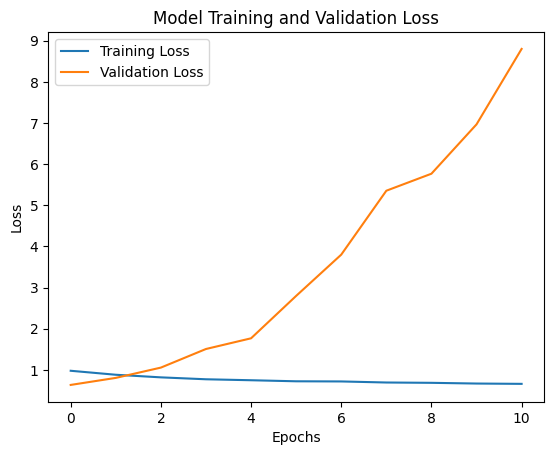

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


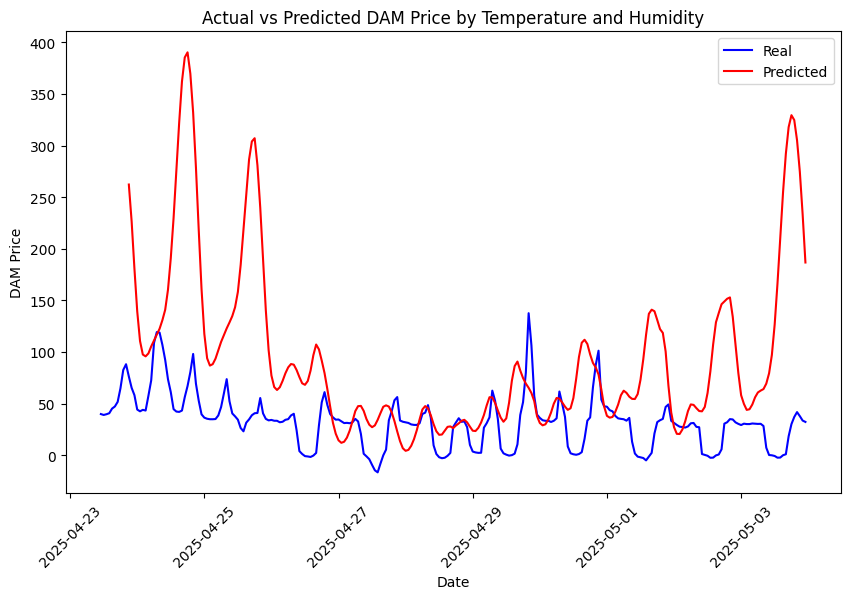

In [19]:
pred = model.predict(test_X)
plt.figure(figsize=(10, 6))
plt.plot(df_test["dam_price"], label="Real", color='blue')
plt.plot(pd.DataFrame(index=df_test.index[lookback:], data=scaler_output.inverse_transform(pred)), label="Predicted", color='red')
plt.xticks(rotation=45)
plt.title('Actual vs Predicted DAM Price by Temperature and Humidity')
plt.xlabel('Date')
plt.ylabel('DAM Price')
plt.legend()
plt.show()

Mivel véges adatom volt, és több paraméterrel is kellett volna dolgoznom ezért az eredmény nem lett annyira jó, de így is látható, hogy valamelyest a trendeket próbálta lekövetni.
